In [1]:
import pandas as pd
import os
import pyproj
from pyproj import Transformer
import cameratransform as ct
import matplotlib.image as image
import matplotlib.pyplot as plt

In [2]:
help(ct.SpatialOrientation)

Help on class SpatialOrientation in module cameratransform.spatial:

class SpatialOrientation(cameratransform.parameter_set.ClassWithParameterSet)
 |  SpatialOrientation(elevation_m=None, tilt_deg=None, roll_deg=None, heading_deg=None, pos_x_m=None, pos_y_m=None)
 |  
 |  The orientation can be represented as a matrix multiplication in *projective coordinates*. First, we define rotation
 |  matrices around the three angles: *tilt*, *roll*, *heading*:
 |  
 |  .. math::
 |      R_{\mathrm{roll}} &=
 |      \begin{pmatrix}
 |      \cos(\alpha_\mathrm{roll}) & \sin(\alpha_\mathrm{roll}) & 0\\
 |      -\sin(\alpha_\mathrm{roll}) & \cos(\alpha_\mathrm{roll}) & 0\\
 |      0 & 0 & 1\\
 |       \end{pmatrix}\\
 |      R_{\mathrm{tilt}} &=
 |      \begin{pmatrix}
 |      1 & 0 & 0\\
 |      0 & \cos(\alpha_\mathrm{tilt}) & \sin(\alpha_\mathrm{tilt}) \\
 |      0 & -\sin(\alpha_\mathrm{tilt}) & \cos(\alpha_\mathrm{tilt}) \\
 |       \end{pmatrix}\\
 |       R_{\mathrm{heading}} &=
 |      \begi

In [3]:
help(pyproj.transform)

Help on function transform in module pyproj.transformer:

transform(p1: Any, p2: Any, x: Any, y: Any, z: Optional[Any] = None, tt: Optional[Any] = None, radians: bool = False, errcheck: bool = False, always_xy: bool = False)
    .. versionadded:: 2.2.0 always_xy
    
    .. deprecated:: 2.6.1
        This function is deprecated. See: :ref:`upgrade_transformer`
    
    x2, y2, z2 = transform(p1, p2, x1, y1, z1)
    
    Transform points between two coordinate systems defined by the
    Proj instances p1 and p2.
    
    The points x1,y1,z1 in the coordinate system defined by p1 are
    transformed to x2,y2,z2 in the coordinate system defined by p2.
    
    z1 is optional, if it is not set it is assumed to be zero (and
    only x2 and y2 are returned). If the optional keyword
    'radians' is True (default is False), then all input and
    output coordinates will be in radians instead of the default
    of degrees for geographic input/output projections.
    If the optional keyword 'er

In [23]:
survey = '101_0002'
df_marks = pd.read_csv(f'../DATA/GCP_IMAGES/{survey}/{survey}_Timestamp.csv')
df_marks['Filename']=df_marks.Sequence.apply(lambda s:f'{survey}_{s:04.0f}.JPG')
df_marks.columns

Index(['GPST', 'Sequence', 'latitude(deg)', 'longitude(deg)', 'height(m)', 'Q',
       'ns', 'sdn(m)', 'sde(m)', 'sdu(m)', 'sdne(m)', 'sdeu(m)', 'sdun(m)',
       'age(s)', 'ratio', 'Filename'],
      dtype='object')

In [24]:
# Parse out the filename from the path
# df_marks['Filename']=[os.path.basename(p).split('\\')[1] for p in df_marks['Path']]
df_marks = df_marks.set_index('Filename')

#tidy up ellipoidal height
# df_marks['EllipsoideHeight'] = df_marks['height(m)'] #df_marks['EllipsoideHight'].str.replace(',Ellh','').astype('float')

# Convert the marks to Eastings and Northings
transformer = Transformer.from_crs(pyproj.CRS('EPSG:4327').to_3d(), 
                                   pyproj.CRS('EPSG:7850+EPSG:5711').to_3d(), 
                                   always_xy=True)
df_marks['UAV_Eastings'], df_marks['UAV_Northings'], df_marks['UAV_Z'] = transformer.transform(df_marks['longitude(deg)'],df_marks['latitude(deg)'],df_marks['height(m)'])

drone_location = df_marks[['UAV_Eastings','UAV_Northings','UAV_Z']]
drone_location

,UAV_Eastings,UAV_Northings,UAV_Z
Filename,,,
101_0002_0001.JPG,394691.977977,6.459654e+06,87.046156
101_0002_0002.JPG,394688.393894,6.459653e+06,87.015649
101_0002_0003.JPG,394685.360623,6.459649e+06,86.907361
101_0002_0004.JPG,394678.669311,6.459641e+06,87.000574
101_0002_0005.JPG,394668.511829,6.459632e+06,87.118894
...,...,...,...
101_0002_0070.JPG,394524.772707,6.459638e+06,86.955962
101_0002_0071.JPG,394539.602337,6.459638e+06,86.968712
101_0002_0072.JPG,394554.521020,6.459639e+06,86.945262


In [37]:
df_meta = pd.read_csv(f'../DATA/GCP_IMAGES/{survey}/drone.csv')
# df_meta = pd.read_csv('../DATA/GCP_IMAGES/101_0002/drone.csv')
#Parse out the filename from the path
df_meta['Filename']=[os.path.basename(p) for p in df_meta['SourceFile']]
print(df_meta.columns)
df_meta = df_meta.set_index('Filename')
gimbal_angles = df_meta[['XMP:GimbalYawDegree', 'XMP:GimbalPitchDegree', 'XMP:GimbalRollDegree','XMP:RelativeAltitude','XMP:FlightYawDegree','XMP:FlightPitchDegree','XMP:FlightRollDegree']]
gimbal_angles = gimbal_angles.rename(columns={'XMP:RelativeAltitude':'UAV_Altitude',
                                      'XMP:GimbalYawDegree':'Gimbal_Yaw',
                                      'XMP:GimbalPitchDegree':'Gimbal_Pitch',
                                      'XMP:GimbalRollDegree':'Gimbal_Roll',
                                      'XMP:FlightYawDegree':'UAV_Yaw',
                                      'XMP:FlightPitchDegree':'UAV_Pitch',
                                      'XMP:FlightRollDegree': 'UAV_Roll',
                                      })
gimbal_angles

Index(['Unnamed: 0', 'SourceFile', 'EXIF:GPSLatitudeRef', 'EXIF:GPSLatitude',
       'EXIF:GPSLongitudeRef', 'EXIF:GPSLongitude', 'EXIF:GPSAltitudeRef',
       'EXIF:GPSAltitude', 'XMP:RtkFlag', 'XMP:DewarpFlag',
       'XMP:AbsoluteAltitude', 'XMP:RelativeAltitude', 'XMP:GPSLatitude',
       'XMP:GPSLongtitude', 'XMP:GimbalRollDegree', 'XMP:GimbalYawDegree',
       'XMP:GimbalPitchDegree', 'XMP:FlightRollDegree', 'XMP:FlightYawDegree',
       'XMP:FlightPitchDegree', 'XMP:CamReverse', 'XMP:GimbalReverse',
       'XMP:CalibratedFocalLength', 'XMP:CalibratedOpticalCenterX',
       'XMP:CalibratedOpticalCenterY', 'Filename'],
      dtype='object')


,Gimbal_Yaw,Gimbal_Pitch,Gimbal_Roll,UAV_Altitude,UAV_Yaw,UAV_Pitch,UAV_Roll
Filename,,,,,,,
101_0002_0019.JPG,46.1,-89.9,0.0,74.99,45.2,6.9,-5.5
101_0002_0035.JPG,-133.1,-89.9,0.0,75.00,-136.8,-23.6,9.0
101_0002_0038.JPG,-133.3,-89.9,0.0,75.04,-133.9,-18.4,0.9
101_0002_0048.JPG,45.9,-89.9,0.0,75.05,43.6,-5.8,7.2
101_0002_0068.JPG,90.6,-44.9,0.0,74.83,88.5,4.3,8.8


In [34]:
# Join the dataframes on filename
df_combined = drone_location.join(gimbal_angles)
df_combined = df_combined.dropna()
df_combined

,UAV_Eastings,UAV_Northings,UAV_Z,Gimbal_Yaw,Gimbal_Pitch,Gimbal_Roll,UAV_Altitude
Filename,,,,,,,
101_0002_0019.JPG,394589.653191,6.459602e+06,86.914216,46.1,-89.9,0.0,74.99
101_0002_0035.JPG,394584.583916,6.459644e+06,86.805765,-133.1,-89.9,0.0,75.00
101_0002_0038.JPG,394552.613041,6.459613e+06,86.834892,-133.3,-89.9,0.0,75.04
101_0002_0048.JPG,394555.890412,6.459664e+06,86.873766,45.9,-89.9,0.0,75.05
101_0002_0068.JPG,394495.813786,6.459636e+06,86.732681,90.6,-44.9,0.0,74.83


In [27]:
df_gcps = pd.read_csv(f'../DATA/GCP_IMAGES/{survey}/{survey}_combinedGCPjsonMRK.csv')
# df_gcps = pd.read_csv('../DATA/GCP_IMAGES/101_0002/101_0002_combinedGCPjsonMRK.csv')
df_gcps = df_gcps.set_index('Filename')
print(df_gcps.columns)
df_gcps = df_gcps[['Easting','Northing','AHD Height','img_x','img_y']].rename(columns={'Easting':'GCP_Eastings',
                                                               'Northing':'GCP_Northings',
                                                               'AHD Height':'GCP_Z'})
df_gcps = df_gcps.join(df_combined)
df_gcps


Index(['Easting', 'Northing', 'AHD Height', 'img_x', 'img_y',
       'EXIF:GPSLatitudeRef', 'EXIF:GPSLatitude', 'EXIF:GPSLongitudeRef',
       'EXIF:GPSLongitude', 'EXIF:GPSAltitudeRef', 'EXIF:GPSAltitude',
       'XMP:RtkFlag', 'XMP:DewarpFlag', 'XMP:AbsoluteAltitude',
       'XMP:RelativeAltitude', 'XMP:GPSLatitude', 'XMP:GPSLongtitude',
       'XMP:GimbalRollDegree', 'XMP:GimbalYawDegree', 'XMP:GimbalPitchDegree',
       'XMP:FlightRollDegree', 'XMP:FlightYawDegree', 'XMP:FlightPitchDegree',
       'XMP:CamReverse', 'XMP:GimbalReverse', 'XMP:CalibratedFocalLength',
       'XMP:CalibratedOpticalCenterX', 'XMP:CalibratedOpticalCenterY',
       'GPSSecondOfWeek', 'GPSWeekNumber', 'NorthOff', 'EastOff', 'VelOff',
       'Latitude', 'Longitude', 'EllipsoideHight', 'Error', 'RTKFlag',
       'UTCTime'],
      dtype='object')


,GCP_Eastings,GCP_Northings,GCP_Z,img_x,img_y,UAV_Eastings,UAV_Northings,UAV_Z,Gimbal_Yaw,Gimbal_Pitch,Gimbal_Roll,UAV_Altitude
Filename,,,,,,,,,,,,
101_0002_0019.JPG,394589.981,6459629.776,11.899,1832,818,394589.653191,6.459602e+06,86.914216,46.1,-89.9,0.0,74.99
101_0002_0019.JPG,394562.677,6459648.234,12.401,222,1058,394589.653191,6.459602e+06,86.914216,46.1,-89.9,0.0,74.99
101_0002_0019.JPG,394571.256,6459639.176,12.185,840,1100,394589.653191,6.459602e+06,86.914216,46.1,-89.9,0.0,74.99
101_0002_0019.JPG,394559.016,6459634.581,12.401,560,1675,394589.653191,6.459602e+06,86.914216,46.1,-89.9,0.0,74.99
101_0002_0019.JPG,394578.040,6459645.103,12.341,882,657,394589.653191,6.459602e+06,86.914216,46.1,-89.9,0.0,74.99
101_0002_0035.JPG,394589.981,6459629.776,11.899,1979,1490,394584.583916,6.459644e+06,86.805765,-133.1,-89.9,0.0,75.00
101_0002_0035.JPG,394562.677,6459648.234,12.401,3572,1228,394584.583916,6.459644e+06,86.805765,-133.1,-89.9,0.0,75.00
101_0002_0035.JPG,394571.256,6459639.176,12.185,2962,1194,394584.583916,6.459644e+06,86.805765,-133.1,-89.9,0.0,75.00
101_0002_0035.JPG,394559.016,6459634.581,12.401,3241,621,394584.583916,6.459644e+06,86.805765,-133.1,-89.9,0.0,75.00


In [28]:
# Setup the camera for each acquisition and project

# DJI P4RTK Camera Sensor Parameters
image_width_px =  5472
image_height_px = 3648
focallength_x_px, focallength_y_px = 3666.666504, 3666.666504 #in pixels

sensor_width_mm = 13.1
sensor_height_mm = sensor_width_mm/image_width_px*image_height_px
focallength_mm = 8.8

# row=df_gcps.iloc[0]

def reprojection_error(row):

    # initialize the camera
    cam = ct.Camera(ct.RectilinearProjection(focallength_x_px=focallength_x_px,
                                            focallength_y_px=focallength_y_px,
                                            image_height_px=image_height_px,
                                            image_width_px=image_width_px,
                                            ),
                    ct.SpatialOrientation(elevation_m=row.UAV_Z,
                                        pos_x_m=row.UAV_Eastings, 
                                        pos_y_m=row.UAV_Northings,
                                        tilt_deg=90+row.Gimbal_Pitch,
                                        heading_deg=row.Gimbal_Yaw,
                                        roll_deg=row.Gimbal_Roll,
                                        ))
    row['reproj_x'],row['reproj_y'] = cam.imageFromSpace([row.GCP_Eastings,row.GCP_Northings,row.GCP_Z])
    return row

df_results = df_gcps.apply(reprojection_error,axis=1)

In [29]:
df_results['error_px'] = ((df_results['img_x']-df_results['reproj_x'])**2+(df_results['img_y']-df_results['reproj_y'])**2)**0.5

In [30]:
df_results['error_px']

Filename
101_0002_0019.JPG     88.612612
101_0002_0019.JPG    169.566075
101_0002_0019.JPG    134.561929
101_0002_0019.JPG    145.825257
101_0002_0019.JPG    141.256529
101_0002_0035.JPG     84.549000
101_0002_0035.JPG     68.359938
101_0002_0035.JPG     45.363679
101_0002_0035.JPG     33.031879
101_0002_0035.JPG     71.504057
101_0002_0038.JPG    159.733025
101_0002_0038.JPG    137.373598
101_0002_0038.JPG    168.616640
101_0002_0048.JPG    127.305800
101_0002_0048.JPG     54.994761
101_0002_0048.JPG     82.976494
101_0002_0048.JPG     95.987251
101_0002_0048.JPG     75.430259
101_0002_0068.JPG    108.593013
101_0002_0068.JPG    108.903431
101_0002_0068.JPG    103.276216
101_0002_0068.JPG     84.317267
101_0002_0068.JPG    112.831982
Name: error_px, dtype: float64

<Axes: xlabel='img_x', ylabel='img_y'>

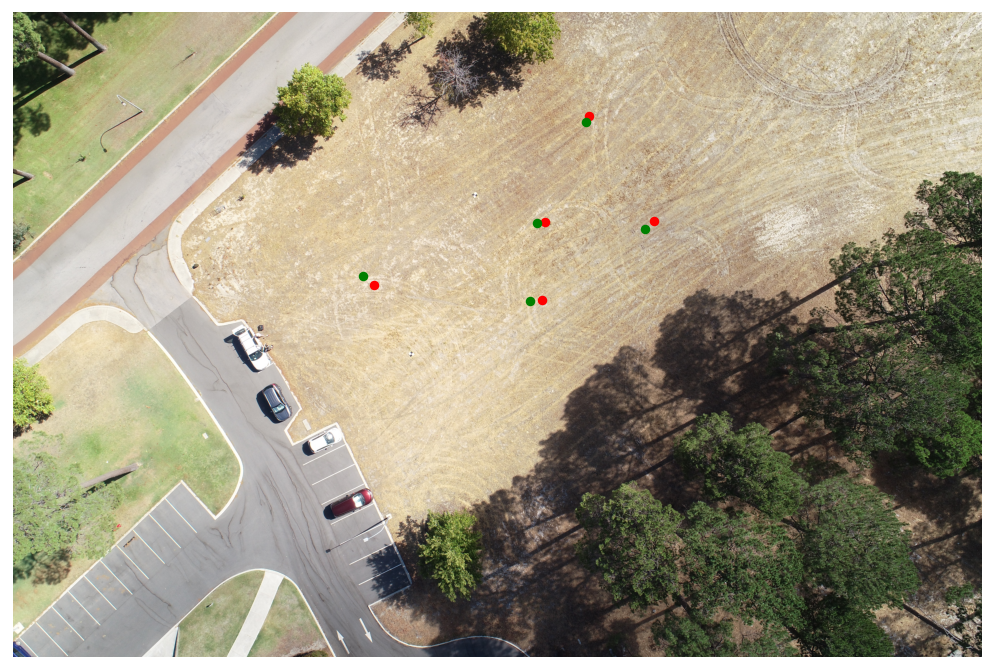

In [33]:
fn = f'{survey}_0035.JPG'
image = plt.imread(f'../DATA/GCP_IMAGES/{fn[0:8]}/{fn}')
fig, ax = plt.subplots(figsize=(10, 10),dpi=125)
ax.imshow(image)
ax.axis('off')
df_results.loc[fn].plot.scatter(x='reproj_x',y='reproj_y',ax=ax,s=20,color='r')
df_results.loc[fn].plot.scatter(x='img_x',y='img_y',ax=ax,s=20,color='g')


<Axes: >

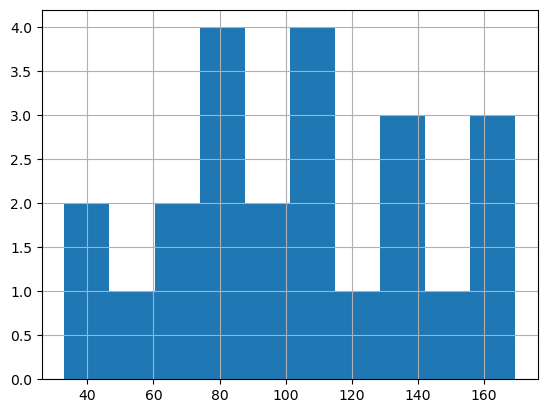

In [31]:
df_results['error_px'].hist()

<Axes: >

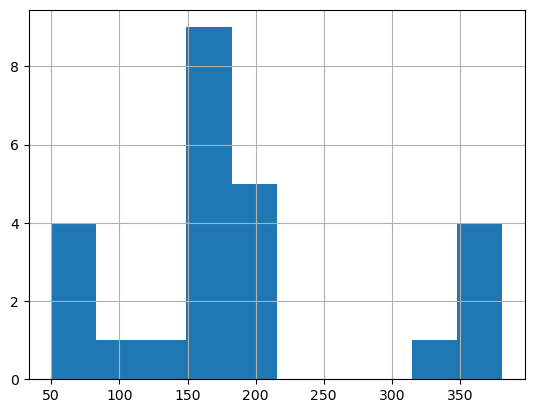

In [37]:
df_results['error_px'].hist()

<Axes: >

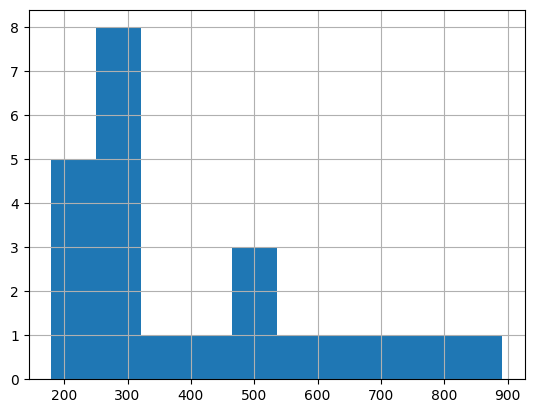

In [10]:
df_results['error_px'].hist()